# Sample Hydrolight read

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_h_dfile(path: str):
    with open(path) as dfile:
        s = next(dfile)
        # Check if valid header
        if s.strip() != r"\begin_header":
            raise IOError(f"Invalid file {path}")
            
        # Raed title
        title_run = next(dfile).strip()
        
        for s in dfile:
            if s.strip() == "\end_header":
                break
        next(dfile)
        
        tmp_dict = {}
        # Read structure
        for s in dfile:
            if s.strip() == "End of grid data.  Beginning blocks of wavelength-dependent data":
                break
                
            if s[0] != " ":
                case = s.strip()
                tmp_dict[case] = []
            elif s[0:3] == "   ":
                arr = np.fromstring(s, sep=" ")
                tmp_dict[case] = np.append(tmp_dict[case], arr)
                
        structure_dict = tmp_dict
        
        wl = []
        wl_dict = {}
        tmp_dict= {}
        for s in dfile:
            if s[0:2] == " w":
                if len(wl) > 0:
                    wl_dict[current_wl] = tmp_dict
                current_wl = float(s.strip().split(" ")[-1])
                wl.append(current_wl)
                tmp_dict = {}
                
            if s[0] != " ":
                case = s.strip()
                tmp_dict[case] = []
            elif s[0:3] == "   ":
                arr = np.fromstring(s, sep=" ")
                tmp_dict[case] = np.append(tmp_dict[case], arr)
        wl_dict[current_wl] = tmp_dict
        wl = np.array(wl)
        
        # Creo un diccionario para guardar los resultados
        _tmp = {}
        # Unidades y coordenadas
        unitsc = {'theta':'deg', 'phi':'deg', 'zeta':"", 'z':'m', 
                 'zkfcn':'m', 'bndmu':"", 'bndphi':'deg', 'omega':'sr', 
                 'wave':'nm', 'waveb':'nm'}
        unitsv = {'acoef':"1/m", 'acoef1':"1/m", 'acoef2':"1/m", 
                  'acoef3':"1/m", 'acoef4':"1/m", 
                  'bcoef':"1/m", 'bcoef1':"1/m", 'bcoef2':"1/m", 
                  'bcoef3':"1/m", 'bcoef4':"1/m", 
                  'bbcoef':"1/m", 'bbcoef1':"1/m", 'bbcoef2':"1/m",
                  'bbcoef3':"1/m", 'bbcoef4':"1/m", 
                  'atten':"1/m", 'albedo':"", 'Eou':"W/m^2 nm", 
                  'Eod':"W/m^2 nm", 'Eu':"W/m^2 nm", 'Ed':"W/m^2 nm", 'mubar_u':("wave","depth"), 
                  'mubar_d':"", 'mubar':"", 'R':"", 
                  'Kd':"1/m", 'Ku':"1/m", 'Ko':"1/m", 
                  'Knet':"1/m", 'KLu':"1/m", 
                  'Rad_Ma':"W/m^2 nm sr", 'Rad_Mz':"W/m^2 nm sr", 
                  'Rad_Pa':"W/m^2 nm sr", 'Rad_Pz':"W/m^2 nm sr", 
                  'Rad_0Ma':"W/m^2 nm sr", 'Rad_0Pa':"W/m^2 nm sr", 
                  'Rad_0Pz':"W/m^2 nm sr",'Rad_0Pz':"W/m^2 nm sr", 
                  'Rad_sky':"W/m^2 nm sr"}
        coordv = {'acoef':("wave","z"), 'acoef1':("wave","z"), 'acoef2':("wave","z"), 
                  'acoef3':("wave","z"), 'acoef4':("wave","z"), 
                  'bcoef':("wave","z"), 'bcoef1':("wave","z"), 'bcoef2':("wave","z"), 
                  'bcoef3':("wave","z"), 'bcoef4':("wave","z"), 
                  'bbcoef':("wave","z"), 'bbcoef1':("wave","z"), 'bbcoef2':("wave","z"),
                  'bbcoef3':("wave","z"), 'bbcoef4':("wave","z"), 
                  'atten':("wave","z"), 'albedo':("wave","z"), 'Eou':("wave","depth"), 
                  'Eod':("wave","depth"), 'Eu':("wave","depth"), 'Ed':("wave","depth"), 'mubar_u':("wave","depth"), 
                  'mubar_d':("wave","depth"), 'mubar':("wave","depth"), 'R':("wave","depth"), 
                  'Kd':("wave","z"), 'Ku':("wave","z"), 'Ko':("wave","z"), 
                  'Knet':("wave","z"), 'KLu':("wave","z"), 
                  'Rad_Ma':("wave","phi","theta"), 'Rad_Mz':("wave","z","phi","theta"), 
                  'Rad_Pa':("wave","phi","theta"), 'Rad_Pz':("wave","z","phi","theta"), 
                  'Rad_0Ma':("wave","phi","theta"), 'Rad_0Pa':("wave","phi","theta"), 
                  'Rad_0Pz':("wave","theta","phi","z"),'Rad_0Pz':("wave","z","phi","theta"), 
                  'Rad_sky':("wave","phi","theta")}

        # Agrego cada coordenada al diccionario
        for key, value in structure_dict.items():
            name = key.split(" (")[0]
            desc = key.split(" (")[1].replace(")","")
            coord = {"dims":name, "data":value, "attrs":{"description":desc, "units":unitsc[name]}}
            _tmp[name] = coord


        # Agrego la variable depth con los valores en el aire
        value = np.insert(_tmp["z"]["data"],0,"-1")
        desc = _tmp["z"]["attrs"]["description"]+" (-1: in air)"
        _tmp["depth"]={"dims":"depth", "data":value, "attrs":{"description":desc, "units":unitsc["zeta"]}}


        # Creo un diccionario para guardar las maginuted que dependen de la longitud de onda
        wd_tmp = {}
        # Lo lleno con ceros
        for key, val in wl_dict[next(iter(wl_dict))].items():
            name = key.split(" (")[0]
            desc = key.split(" (")[1].replace(")","")
            name = name+"".join([n for n in desc if n.isdigit()])
            wd_tmp[name] = {"data":np.zeros((len(wl), len(val))),
                            "dims":(),
                          "attrs":{"description":desc, "units":unitsv[name]}}

        # Lo relleno para cada longitud de onda
        i = 0
        for key_wl, val_wl in wl_dict.items():
            for key, val in val_wl.items():
                name = key.split(" (")[0]
                desc = key.split(" (")[1].replace(")","")
                name = name+"".join([n for n in desc if n.isdigit()])
                wd_tmp[name]["data"][i,:] = val
                wd_tmp[name]["dims"] = coordv[name]
            i+=1

        # Cambio la forma de los arrays
        # TODO: Check this!
        wd_tmp["Rad_Ma"]["data"] = wd_tmp["Rad_Ma"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                     len(_tmp["phi"]["data"]), 
                                                                     len(_tmp["theta"]["data"])))
        wd_tmp["Rad_Ma"]["data"][0,:,-1] = wd_tmp["Rad_Ma"]["data"][0,0,-1]

        wd_tmp["Rad_Pa"]["data"] = wd_tmp["Rad_Pa"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                     len(_tmp["phi"]["data"]), 
                                                                     len(_tmp["theta"]["data"])))
        wd_tmp["Rad_Pa"]["data"][0,:,-1] = wd_tmp["Rad_Pa"]["data"][0,0,-1]

        wd_tmp["Rad_0Ma"]["data"] = wd_tmp["Rad_0Ma"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                       len(_tmp["phi"]["data"]), 
                                                                       len(_tmp["theta"]["data"])))
        wd_tmp["Rad_0Ma"]["data"][0,:,-1] = wd_tmp["Rad_0Ma"]["data"][0,0,-1]

        wd_tmp["Rad_0Pa"]["data"] = wd_tmp["Rad_0Pa"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                       len(_tmp["phi"]["data"]), 
                                                                       len(_tmp["theta"]["data"])))
        wd_tmp["Rad_0Pa"]["data"][0,:,-1] = wd_tmp["Rad_0Pa"]["data"][0,0,-1]


        wd_tmp["Rad_sky"]["data"] = wd_tmp["Rad_sky"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                       len(_tmp["phi"]["data"]), 
                                                                       len(_tmp["theta"]["data"])))


        wd_tmp["Rad_Mz"]["data"] = wd_tmp["Rad_Mz"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                      len(_tmp["z"]["data"]),
                                                                      len(_tmp["phi"]["data"]), 
                                                                      len(_tmp["theta"]["data"])))
        for i in range(len(_tmp["z"]["data"])):
            wd_tmp["Rad_Mz"]["data"][0,i,:,-1] = wd_tmp["Rad_Mz"]["data"][0,i,0,-1]

        wd_tmp["Rad_Pz"]["data"] = wd_tmp["Rad_Pz"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                      len(_tmp["z"]["data"]),
                                                                      len(_tmp["phi"]["data"]), 
                                                                      len(_tmp["theta"]["data"])))
        for i in range(len(_tmp["z"]["data"])):
            wd_tmp["Rad_Pz"]["data"][0,i,:,-1] = wd_tmp["Rad_Pz"]["data"][0,i,0,-1]

        wd_tmp["Rad_0Pz"]["data"] = wd_tmp["Rad_0Pz"]["data"].reshape((len(_tmp["wave"]["data"]), 
                                                                      len(_tmp["z"]["data"]),
                                                                      len(_tmp["phi"]["data"]), 
                                                                      len(_tmp["theta"]["data"])))
        for i in range(len(_tmp["z"]["data"])):
            wd_tmp["Rad_0Pz"]["data"][0,i,:,-1] = wd_tmp["Rad_0Pz"]["data"][0,i,0,-1]

        _tmp["depth"]={"dims":"depth", "data":value, "attrs":{"description":desc, "units":unitsc["zeta"]}}

        # Add Rrs by hand
        wd_tmp["Rrs"] = {"data":(wd_tmp["Rad_Ma"]["data"][:,0,-1]/wd_tmp["Ed"]["data"][:,0]),
                        "dims":"wave",
                        "attrs":{"description":"Remote sensing reflectance", "units":"1/sr"}}

        # Agrego las variables dependientes de la longitud de onda a las coordenadas
        _tmp.update(wd_tmp)


        # Lo convierto en un xarray
        s = xr.Dataset.from_dict(_tmp)
        s.attrs["title"] = title_run
        return s

In [11]:
s = read_h_dfile("../tesis/objetivos/2_simulacion_espectros/HYDROLIGHT/data/Drootname.txt")
s.to_netcdf("pepe.nc","w")
s

<xarray.Dataset>
Dimensions:  (theta: 10, phi: 24, zeta: 5, z: 5, zkfcn: 5, bndmu: 10,
              bndphi: 24, omega: 10, wave: 15, waveb: 16, depth: 6)
Coordinates:
  * theta    (theta) float64 87.5 80.0 70.0 60.0 50.0 40.0 30.0 20.0 10.0 0.0
  * phi      (phi) float64 0.0 15.0 30.0 45.0 60.0 ... 300.0 315.0 330.0 345.0
  * zeta     (zeta) float64 0.0 8.123 16.25 24.37 32.49
  * z        (z) float64 0.0 5.0 10.0 15.0 20.0
  * zkfcn    (zkfcn) float64 0.005 5.005 10.01 15.01 20.0
  * bndmu    (bndmu) float64 0.08716 0.2588 0.4226 0.5736 ... 0.9659 0.9962 1.0
  * bndphi   (bndphi) float64 0.1309 0.3927 0.6545 0.9163 ... 5.629 5.89 6.152
  * omega    (omega) float64 0.02282 0.04494 0.04288 ... 0.007924 0.02391
  * wave     (wave) float64 410.0 430.0 450.0 470.0 ... 630.0 650.0 670.0 690.0
  * waveb    (waveb) float64 400.0 420.0 440.0 460.0 ... 640.0 660.0 680.0 700.0
  * depth    (depth) float64 -1.0 0.0 5.0 10.0 15.0 20.0
Data variables: (12/39)
    acoef    (wave, z) float64 0.1913 0.1913 0.1913 ... 0.5555 0.5555 0.5555
    acoef1   (wave, z) float64 0.005997 0.005997 0.005997 ... 0.5157 0.5157
    acoef2   (wave, z) float64 0.1414 0.1414 0.1414 ... 0.03895 0.03895 0.03895
    acoef3   (wave, z) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    acoef4   (wave, z) float64 0.04398 0.04398 0.04398 ... 0.0008727 0.0008727
    bcoef    (wave, z) float64 1.433 1.433 1.433 1.433 ... 1.428 1.428 1.428
    ...       ...
    Rad_Pz   (wave, z, phi, theta) float64 0.01336 0.01191 ... 2.724e-05 0.0
    Rad_0Ma  (wave, phi, theta) float64 0.06067 0.03409 0.01371 ... 0.001667 0.0
    Rad_0Pa  (wave, phi, theta) float64 0.2212 0.1416 0.08263 ... 0.04759 0.0
    Rad_0Pz  (wave, z, phi, theta) float64 0.0004638 0.0 ... 2.08e-19 0.0
    Rad_sky  (wave, phi, theta) float64 0.2212 0.1416 0.08263 ... 0.04759 0.0
    Rrs      (wave) float64 0.002757 0.002688 0.002993 ... 0.001014 0.001005
Attributes:
    title:    HydroLight Run Title: Replace the rootname and title (25 APR 20...

In [5]:
import pint

ureg = pint.UnitRegistry()

def pcolormesh_polar_cheap(da, r=None, theta=None, add_labels=False, **kwargs):
    """https://stackoverflow.com/questions/64664428/xarray-polar-pcolormesh-with-low-overhead-axis-coordinate-transformation"""
    if r is None:
        r = da.dims[0]
    if theta is None:
        theta = da.dims[1]
    
    try:
        theta_units = ureg.Unit(da[theta].attrs["units"])
    except KeyError:
        theta_units = ureg.rad

    if theta_units != ureg.rad:
        theta_rad = f"{theta}_rad"
        theta_rad_values = ureg.Quantity(da[theta].values, theta_units).to(ureg.rad).magnitude
        da_plot = da.assign_coords(**{theta_rad: (theta, theta_rad_values)})
        da_plot[theta_rad].attrs = da[theta].attrs
        da_plot[theta_rad].attrs["units"] = "rad"
    else:
        theta_rad = theta
        da_plot = da
    
    kwargs["x"] = theta_rad
    kwargs["y"] = r
    kwargs["add_labels"] = add_labels

    try:
        subplot_kws = kwargs["subplot_kws"]
    except KeyError:
        subplot_kws = {}
    subplot_kws["projection"] = "polar"
    
    return da_plot.plot.pcolormesh(
        **kwargs,
        subplot_kws=subplot_kws,
    )

### Algunos ejemplos

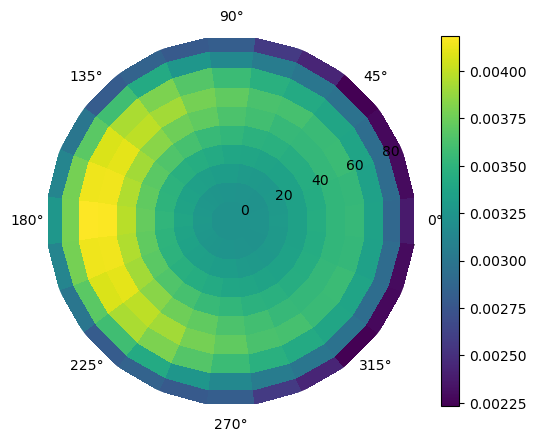

In [17]:
pcolormesh_polar_cheap(s.Rad_Ma.sel(wave=410), r="theta", theta="phi")

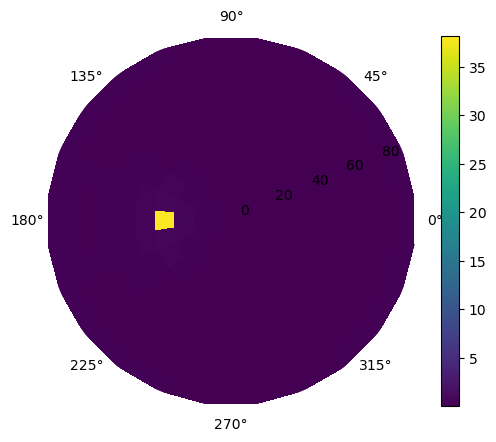

In [19]:
pcolormesh_polar_cheap(s.Rad_0Pa.sel(wave=410), r="theta", theta="phi")

In [7]:
Rrs = pd.read_excel("/Users/fnemina/Documents/IG/proyectos/tesis/objetivos/2_simulacion_espectros/HYDROLIGHT/data/chl5/Mrootname.xlsx",sheet_name="Rrs", skiprows=3, index_col="in air");
R = pd.read_excel("/Users/fnemina/Documents/IG/proyectos/tesis/objetivos/2_simulacion_espectros/HYDROLIGHT/data/chl5/Mrootname.xlsx",sheet_name="R", skiprows=3, index_col="wavelen");

/Users/fnemina/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/fnemina/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


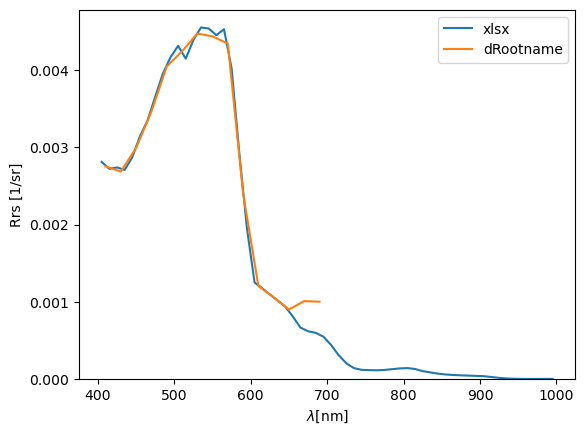

In [20]:
Rrs["Rrs"].plot(label="xlsx")
s.Rrs.plot(label="dRootname")
plt.xlabel(r"$\lambda$[nm]")
#plt.xlim(400,700)
plt.ylim(bottom=0)
plt.legend()
plt.show()

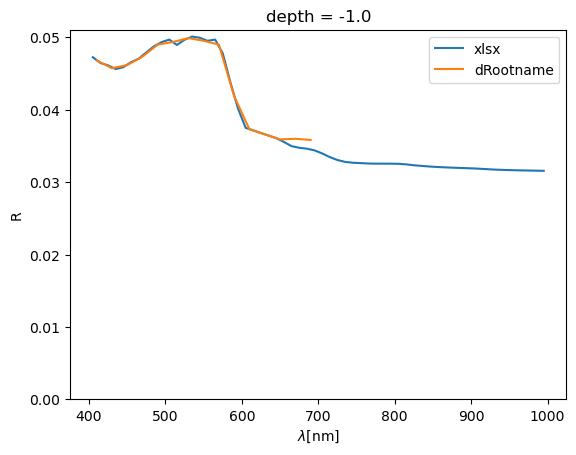

In [21]:
R["in air"].plot(label="xlsx")
(s.R.sel(depth=-1)).plot(label="dRootname")
plt.xlabel(r"$\lambda$[nm]")
#plt.xlim(400,700)
plt.ylim(bottom=0)
plt.legend()
plt.show()